In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn scipy -q

In [ ]:
# 2. Imports & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score,
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from scipy.stats import ttest_rel

In [ ]:
# 3. Load & Prepare the Wine Quality Dataset (Red)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep=';')
df['label'] = (df['quality'] >= 7).astype(int)
X = df.drop(['quality', 'label'], axis=1)
y = df['label']

# Print class balance
print(f"Shape: {X.shape} | Class balance:\n{y.value_counts(normalize=True)}")

# Standardize features (important for LogReg & SVM)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

Shape: (1599, 11) | Class balance:
label
0    0.86429
1    0.13571
Name: proportion, dtype: float64


In [ ]:
# 4. Set Up Cross-Validation, Models, Oversamplers
RANDOM_STATE = 42
N_SPLITS = 3

CLASSIFIERS = {
    "RandomForest": RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(
        max_iter=2000, solver='lbfgs', random_state=RANDOM_STATE),
    "SVM": SVC(kernel="rbf", probability=True, class_weight='balanced', random_state=RANDOM_STATE)
}

OVERSAMPLERS = {
    "No Oversampling": None,
    "RandomOver": RandomOverSampler(random_state=RANDOM_STATE),
    "SMOTE": SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    "ADASYN": ADASYN(random_state=RANDOM_STATE, n_neighbors=5)
}

METRICS = ["f1", "roc_auc", "precision", "recall", "mcc"]
results = []
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# For per-fold t-test statistics (RandomForest only, but you can extend easily)
all_fold_f1s = {method: [] for method in OVERSAMPLERS}

In [ ]:
# 5. Cross-Validation Loop
# (Also: Save last fold results for SMOTE+RandomForest for visualizations)
for oversampler_name, oversampler in OVERSAMPLERS.items():
    for clf_name, clf_proto in CLASSIFIERS.items():
        print(f"\nEvaluating: {oversampler_name} + {clf_name}")
        fold_metrics = {metric: [] for metric in METRICS}
        fold_f1s = []
        if oversampler_name == "SMOTE" and clf_name == "RandomForest":
            save_fold_for_viz = N_SPLITS - 1
        for fold_num, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            if oversampler:
                X_res, y_res = oversampler.fit_resample(X_tr, y_tr)
            else:
                X_res, y_res = X_tr, y_tr
            clf = clf_proto.__class__(**clf_proto.get_params())
            clf.fit(X_res, y_res)
            y_pred = clf.predict(X_te)
            # Probabilities or decision function for ROC/PRC
            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_te)[:, 1]
            elif hasattr(clf, "decision_function"):
                try:
                    y_proba = clf.decision_function(X_te)
                    if y_proba.ndim > 1:
                        y_proba = y_proba[:, 1]
                except:
                    y_proba = y_pred
            else:
                y_proba = y_pred
            # Save metrics
            f1 = f1_score(y_te, y_pred)
            fold_metrics["f1"].append(f1)
            fold_metrics["roc_auc"].append(roc_auc_score(y_te, y_proba))
            fold_metrics["precision"].append(precision_score(y_te, y_pred, zero_division=0))
            fold_metrics["recall"].append(recall_score(y_te, y_pred))
            fold_metrics["mcc"].append(matthews_corrcoef(y_te, y_pred))
            # Save F1s per fold for RandomForest (for t-test/statistics)
            if clf_name == "RandomForest":
                fold_f1s.append(f1)
            # Save last fold visualization data for SMOTE+RandomForest
            if (
                oversampler_name == "SMOTE"
                and clf_name == "RandomForest"
                and fold_num == save_fold_for_viz
            ):
                y_te_last = y_te
                y_pred_last = y_pred
                y_proba_last = y_proba
        # Store all per-fold F1s for RandomForest for significance testing
        if clf_name == "RandomForest":
            all_fold_f1s[oversampler_name] = fold_f1s
        # Add means and stds to results table
        results.append({
            "Oversampler": oversampler_name,
            "Classifier": clf_name,
            **{f"{metric}_mean": np.mean(fold_metrics[metric]) for metric in METRICS},
            **{f"{metric}_std": np.std(fold_metrics[metric]) for metric in METRICS}
        })


Evaluating: No Oversampling + RandomForest

Evaluating: No Oversampling + LogisticRegression

Evaluating: No Oversampling + SVM

Evaluating: RandomOver + RandomForest

Evaluating: RandomOver + LogisticRegression

Evaluating: RandomOver + SVM

Evaluating: SMOTE + RandomForest

Evaluating: SMOTE + LogisticRegression

Evaluating: SMOTE + SVM

Evaluating: BorderlineSMOTE + RandomForest

Evaluating: BorderlineSMOTE + LogisticRegression

Evaluating: BorderlineSMOTE + SVM

Evaluating: ADASYN + RandomForest

Evaluating: ADASYN + LogisticRegression

Evaluating: ADASYN + SVM


In [ ]:
# 6. Show Results DataFrame
results_df = pd.DataFrame(results)
print("\nCross-validated results:")
display(results_df)


Cross-validated results:


,Oversampler,Classifier,f1_mean,roc_auc_mean,precision_mean,recall_mean,mcc_mean,f1_std,roc_auc_std,precision_std,recall_std,mcc_std
0,No Oversampling,RandomForest,0.570022,0.895516,0.735935,0.465753,0.537139,0.062564,0.033864,0.065730,0.059187,0.068576
1,No Oversampling,LogisticRegression,0.414960,0.863476,0.598856,0.317922,0.376765,0.029631,0.013253,0.019530,0.029369,0.027411
2,No Oversampling,SVM,0.516206,0.877139,0.390752,0.764840,0.447468,0.004470,0.017375,0.011561,0.049981,0.010497
3,RandomOver,RandomForest,0.574934,0.905434,0.652923,0.516426,0.522883,0.040317,0.017355,0.040176,0.053624,0.041935
4,RandomOver,LogisticRegression,0.496360,0.866306,0.360535,0.797121,0.430155,0.028198,0.013451,0.016413,0.064789,0.041865
5,RandomOver,SVM,0.523057,0.873930,0.405067,0.741819,0.452080,0.009221,0.020744,0.006197,0.054077,0.016442
6,SMOTE,RandomForest,0.575777,0.905610,0.540238,0.617643,0.505659,0.045152,0.021643,0.050041,0.044547,0.053435
7,SMOTE,LogisticRegression,0.500041,0.861938,0.364397,0.797121,0.434191,0.030285,0.013088,0.018594,0.064789,0.044105
8,SMOTE,SVM,0.517687,0.869467,0.404941,0.718798,0.442924,0.017323,0.015949,0.006369,0.047714,0.024440
9,BorderlineSMOTE,RandomForest,0.603254,0.902936,0.578924,0.631469,0.539080,0.042873,0.013302,0.042744,0.054926,0.050176


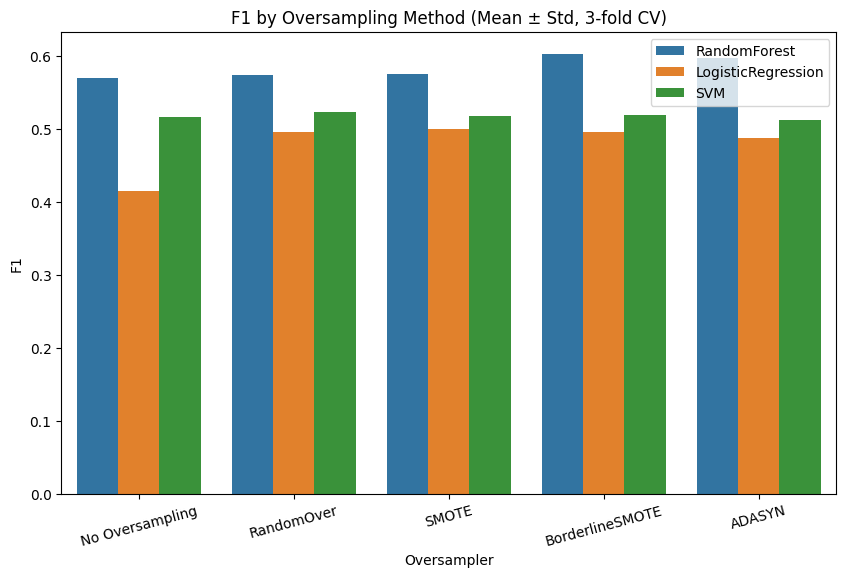

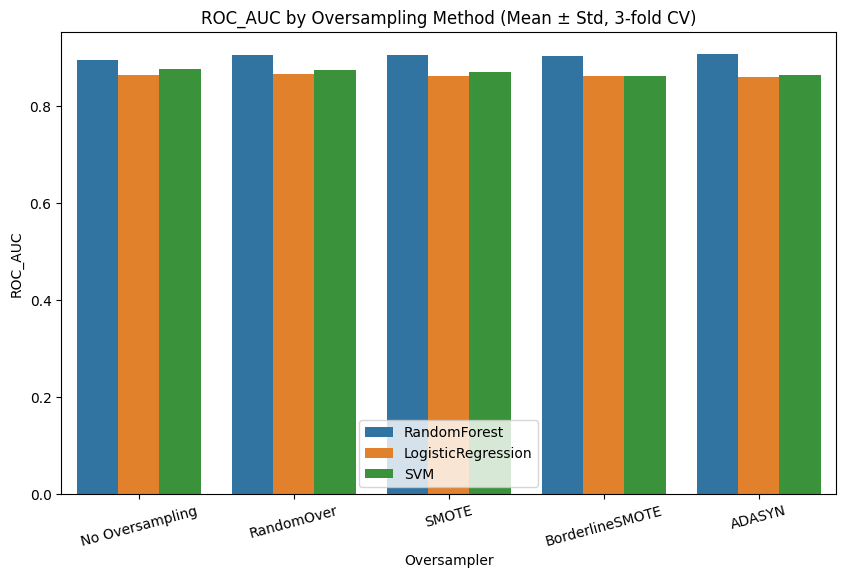

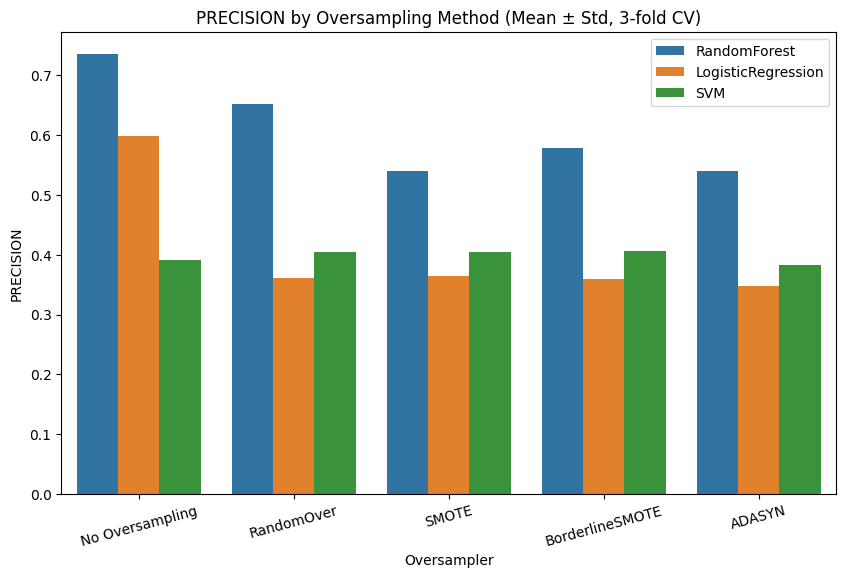

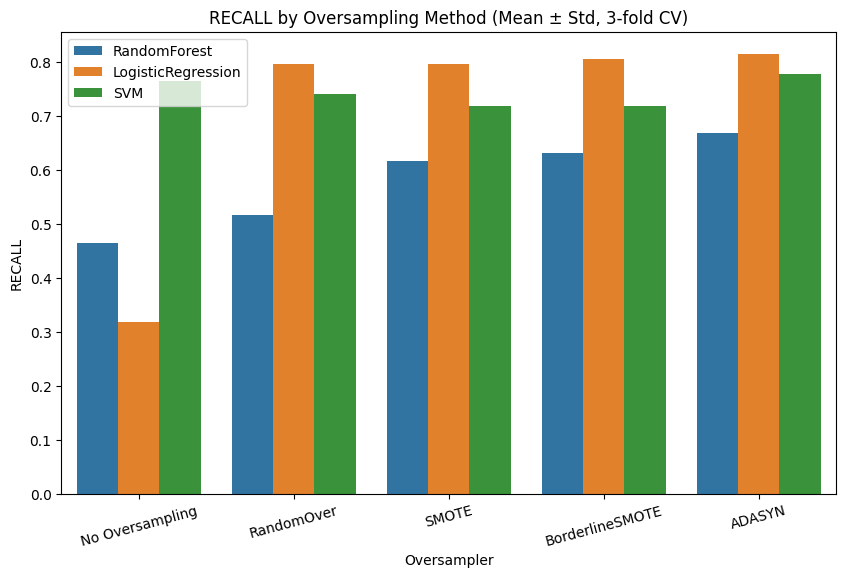

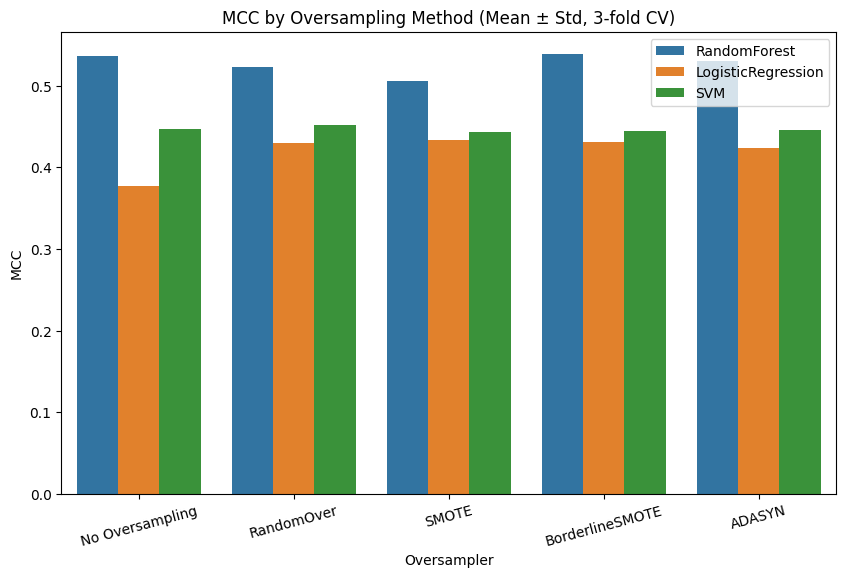

In [ ]:
# 7. Metrics Barplots by Method/Classifer
for metric in METRICS:
    plt.figure(figsize=(10,6))
    sns.barplot(data=results_df, x="Oversampler", y=f"{metric}_mean", hue="Classifier",
                errorbar="sd", capsize=.2)
    plt.title(f"{metric.upper()} by Oversampling Method (Mean ± Std, {N_SPLITS}-fold CV)")
    plt.ylabel(metric.upper())
    plt.legend(loc="best")
    plt.xticks(rotation=15)
    plt.show()


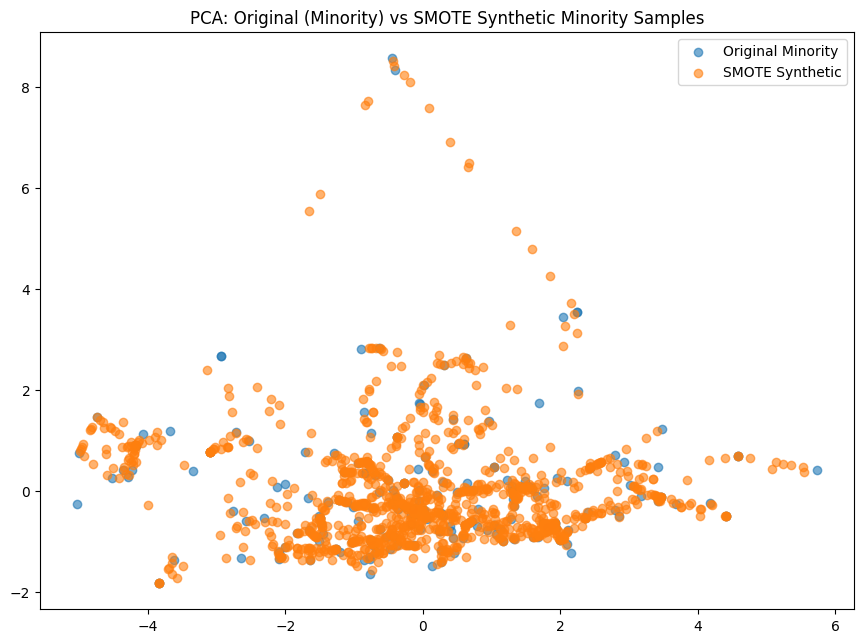

In [ ]:
# 8. PCA Visualization of Synthetic Minority Points (SMOTE)
smote = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X, y)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
proj_X_orig = pca.fit_transform(X[y==1])
proj_X_syn = pca.transform(X_res[len(X):][y_res[len(X):]==1])

plt.figure(figsize=(10.5,7.5))
plt.scatter(proj_X_orig[:,0], proj_X_orig[:,1], label="Original Minority", alpha=0.6)
plt.scatter(proj_X_syn[:,0], proj_X_syn[:,1], label="SMOTE Synthetic", alpha=0.6)
plt.title("PCA: Original (Minority) vs SMOTE Synthetic Minority Samples")
plt.legend()
plt.show()

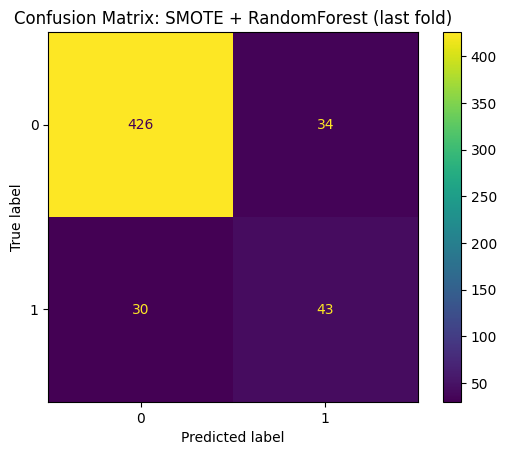

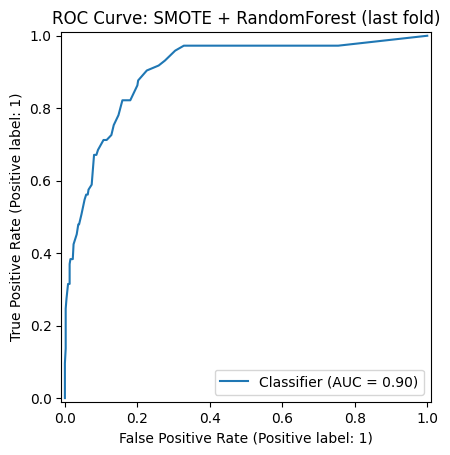

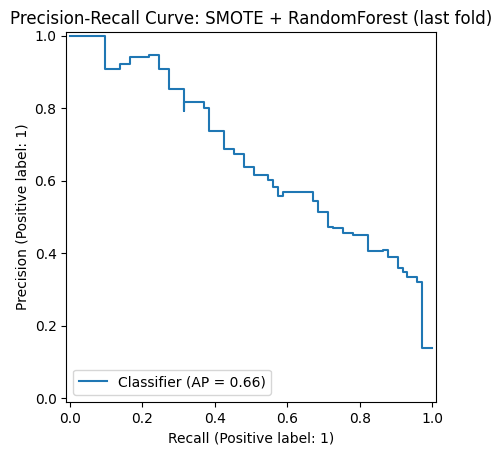

In [ ]:
# 9. Confusion Matrix, ROC Curve, Precision-Recall Curve (SMOTE+RandomForest last fold)
ConfusionMatrixDisplay.from_predictions(y_te_last, y_pred_last)
plt.title("Confusion Matrix: SMOTE + RandomForest (last fold)")
plt.show()
RocCurveDisplay.from_predictions(y_te_last, y_proba_last)
plt.title("ROC Curve: SMOTE + RandomForest (last fold)")
plt.show()
PrecisionRecallDisplay.from_predictions(y_te_last, y_proba_last)
plt.title("Precision-Recall Curve: SMOTE + RandomForest (last fold)")
plt.show()

In [ ]:
# 10. Statistical Significance Tests (paired t-test, F1 per fold, RandomForest)
print("\nPaired t-test on F1 (RandomForest) vs. No Oversampling, per oversampler:")
baseline_f1s = all_fold_f1s["No Oversampling"]
for method in ["RandomOver", "SMOTE", "BorderlineSMOTE", "ADASYN"]:
    method_f1s = all_fold_f1s[method]
    if len(method_f1s) == len(baseline_f1s):
        t_stat, p_val = ttest_rel(baseline_f1s, method_f1s)
        print(f"{method}: t-stat = {t_stat:.3f}, p = {p_val:.4f}")


Paired t-test on F1 (RandomForest) vs. No Oversampling, per oversampler:
RandomOver: t-stat = -0.219, p = 0.8469
SMOTE: t-stat = -0.145, p = 0.8981
BorderlineSMOTE: t-stat = -0.787, p = 0.5138
ADASYN: t-stat = -0.722, p = 0.5452


In [ ]:
# 11. Save Results Table (Optional)
results_df.to_csv("smote_wine_quality_results.csv", index=False)



---



scikit-learn version: 1.6.1
imbalanced-learn version: 0.13.0
SMOTE Evaluation Framework
Wine Quality loaded: 1599 samples, 11 features
Breast Cancer loaded: 569 samples, 30 features

Evaluating WineQuality dataset...
Class distribution: {0: np.int64(1382), 1: np.int64(217)}
Class balance: {0: 0.8642901813633521, 1: 0.1357098186366479}

Testing No_Oversampling...

Testing RandomOver...

Testing SMOTE...

Testing BorderlineSMOTE...

Testing ADASYN...

STATISTICAL ANALYSIS - WineQuality

RandomForest - F1 Score Comparisons:
----------------------------------------
RandomOver      vs Baseline: t=-1.606, p=0.1835    (μ=0.633 vs μ=0.604)
SMOTE           vs Baseline: t=-0.150, p=0.8883    (μ=0.609 vs μ=0.604)
BorderlineSMOTE vs Baseline: t=-0.195, p=0.8547    (μ=0.609 vs μ=0.604)
ADASYN          vs Baseline: t=-0.823, p=0.4566    (μ=0.631 vs μ=0.604)

LogisticRegression - F1 Score Comparisons:
----------------------------------------
RandomOver      vs Baseline: t=-1.920, p=0.1273    (μ=0.514

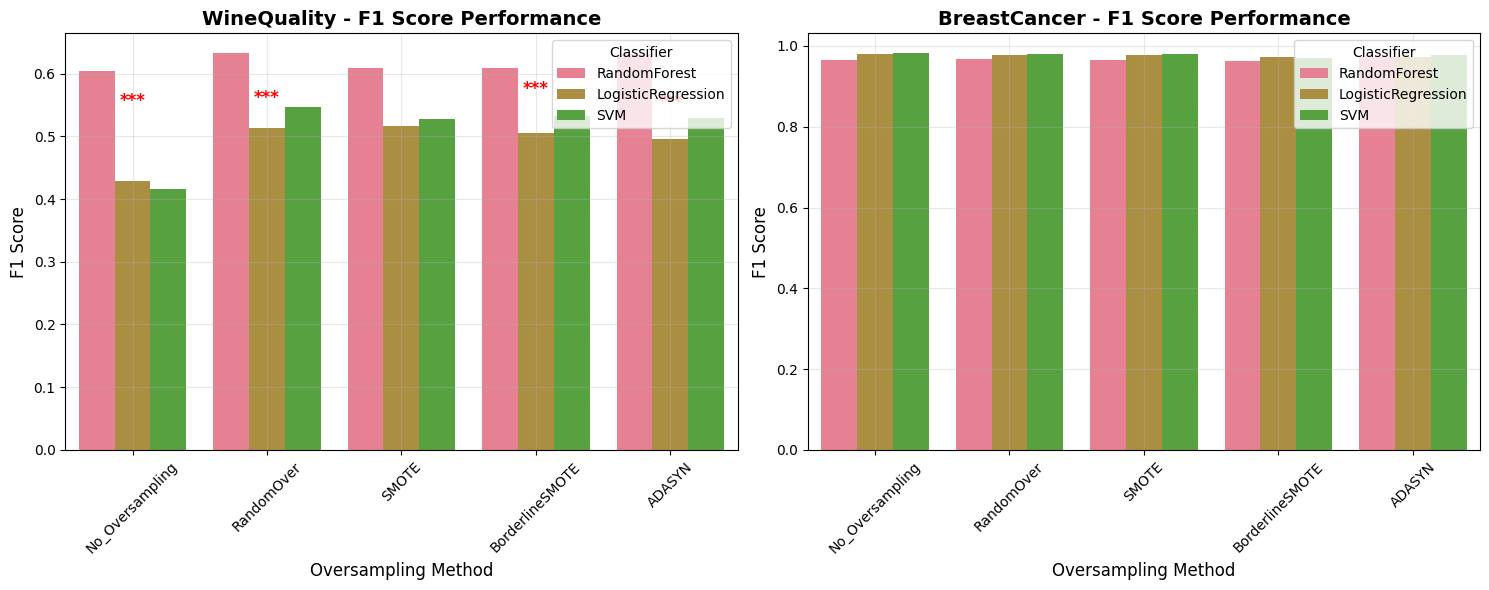

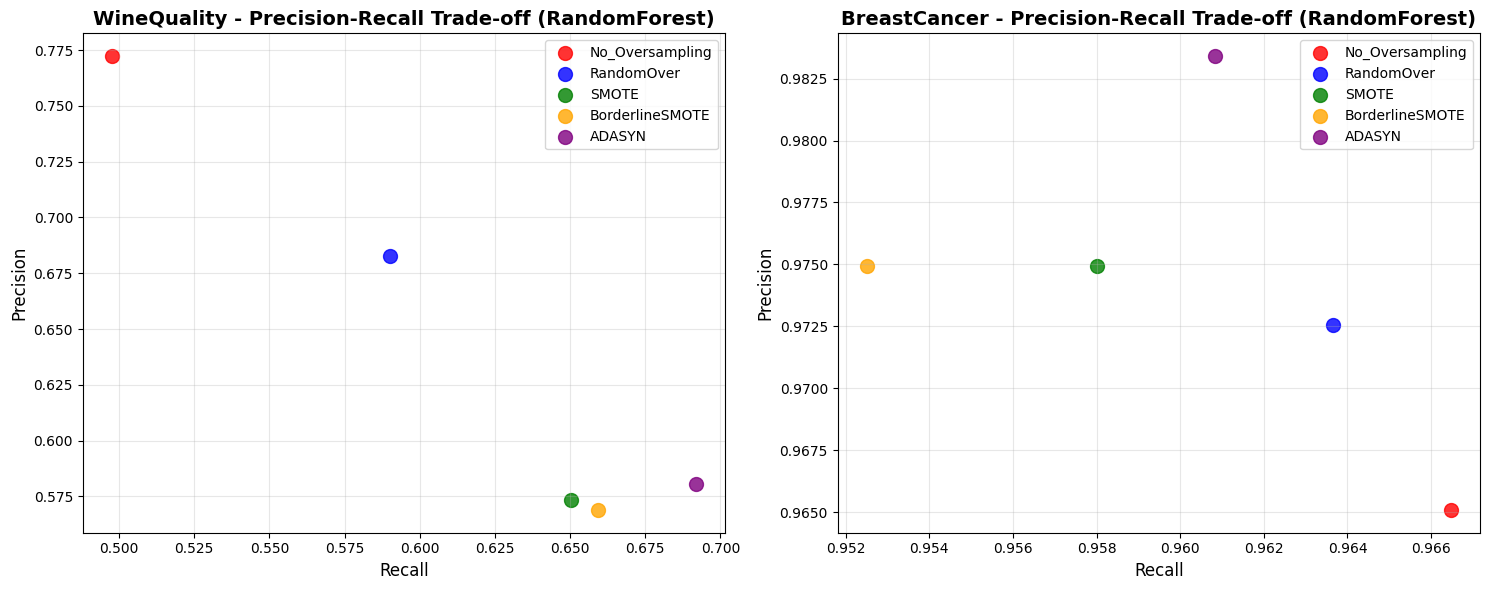

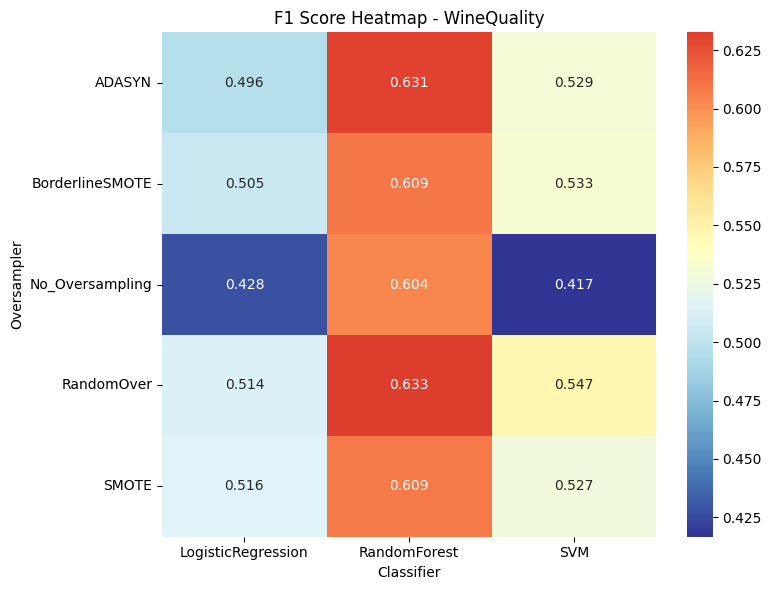

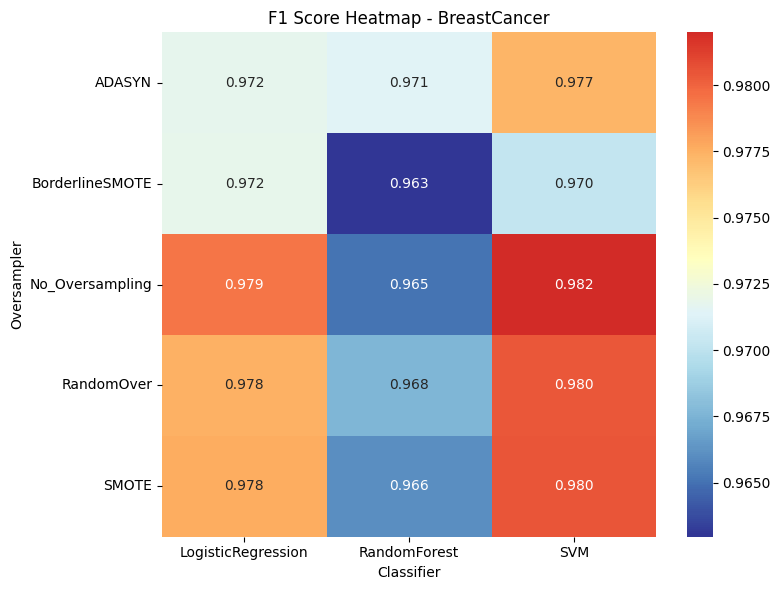

SUMMARY TABLE FOR RESEARCH PAPER - Random Forest Results
Metric                           f1  precision  recall
Dataset      Oversampler                              
BreastCancer ADASYN           0.971      0.983   0.961
             BorderlineSMOTE  0.963      0.975   0.953
             No_Oversampling  0.965      0.965   0.966
             RandomOver       0.968      0.973   0.964
             SMOTE            0.966      0.975   0.958
WineQuality  ADASYN           0.631      0.580   0.692
             BorderlineSMOTE  0.609      0.569   0.659
             No_Oversampling  0.604      0.772   0.498
             RandomOver       0.633      0.683   0.590
             SMOTE            0.609      0.573   0.650

IMPROVEMENT OVER NO OVERSAMPLING (Random Forest)

WineQuality:
  RandomOver     :  +4.80% F1 improvement
  SMOTE          :  +0.83% F1 improvement
  BorderlineSMOTE:  +0.83% F1 improvement
  ADASYN         :  +4.47% F1 improvement

BreastCancer:
  RandomOver     :  +0.31% F1 improv

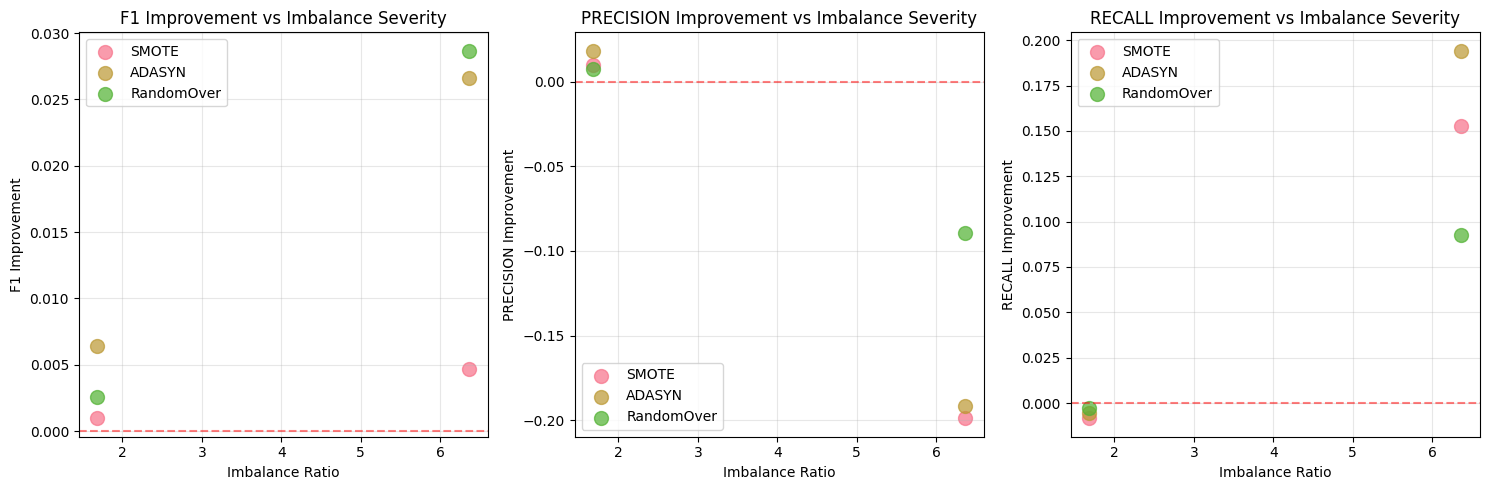

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score,
    matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("scikit-learn version:", __import__("sklearn").__version__)
print("imbalanced-learn version:", __import__("imblearn").__version__)

# 1. Load Datasets
def load_datasets():
    """Load multiple datasets for comprehensive evaluation"""
    datasets = {}

    # Wine Quality Dataset
    try:
        wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
        X_wine = wine_df.drop('quality', axis=1)
        y_wine = (wine_df['quality'] >= 7).astype(int)
        datasets['WineQuality'] = (X_wine, y_wine)
        print(f"Wine Quality loaded: {X_wine.shape[0]} samples, {X_wine.shape[1]} features")
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")

    # Breast Cancer Dataset
    try:
        breast_data = load_breast_cancer()
        X_breast = pd.DataFrame(breast_data.data, columns=breast_data.feature_names)
        y_breast = pd.Series(breast_data.target)
        datasets['BreastCancer'] = (X_breast, y_breast)
        print(f"Breast Cancer loaded: {X_breast.shape[0]} samples, {X_breast.shape[1]} features")
    except Exception as e:
        print(f"Error loading Breast Cancer dataset: {e}")

    return datasets

# 2. Evaluation Framework
def evaluate_dataset(X, y, dataset_name, n_splits=5, random_state=42):
    """Evaluate oversampling techniques on a single dataset"""

    # Define classifiers
    classifiers = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "LogisticRegression": LogisticRegression(max_iter=2000, random_state=random_state),
        "SVM": SVC(kernel="rbf", probability=True, random_state=random_state)
    }

    # Define oversampling techniques
    oversamplers = {
        "No_Oversampling": None,
        "RandomOver": RandomOverSampler(random_state=random_state),
        "SMOTE": SMOTE(random_state=random_state, k_neighbors=min(5, len(y[y==1])-1)),
        "BorderlineSMOTE": BorderlineSMOTE(random_state=random_state, k_neighbors=min(5, len(y[y==1])-1)),
        "ADASYN": ADASYN(random_state=random_state, n_neighbors=min(5, len(y[y==1])-1))
    }

    # Metrics to evaluate
    metrics = ["f1", "roc_auc", "precision", "recall", "balanced_accuracy", "kappa"]

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Store results
    results = []
    fold_scores = {name: {clf: {metric: [] for metric in metrics} for clf in classifiers}
                   for name in oversamplers}

    print(f"\nEvaluating {dataset_name} dataset...")
    print(f"Class distribution: {dict(y.value_counts())}")
    print(f"Class balance: {y.value_counts(normalize=True).to_dict()}")

    # Main evaluation loop
    for oversampler_name, oversampler in oversamplers.items():
        print(f"\nTesting {oversampler_name}...")

        for clf_name, classifier in classifiers.items():
            fold_metrics = {metric: [] for metric in metrics}

            for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                # Create pipeline
                if oversampler is not None:
                    # Check if minority class has enough samples for k_neighbors
                    minority_count = min(y_train.value_counts())
                    if minority_count < 2:
                        print(f"Warning: Not enough minority samples in fold {fold} for {oversampler_name}")
                        continue

                    pipeline = ImbPipeline([
                        ('scaler', StandardScaler()),
                        ('oversampler', oversampler),
                        ('classifier', classifier)
                    ])
                else:
                    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('classifier', classifier)
                    ])

                try:
                    # Fit and predict
                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)
                    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['classifier'], 'predict_proba') else y_pred

                    # Calculate metrics
                    fold_metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
                    fold_metrics['roc_auc'].append(roc_auc_score(y_test, y_proba))
                    fold_metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
                    fold_metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
                    fold_metrics['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
                    fold_metrics['kappa'].append(cohen_kappa_score(y_test, y_pred))

                except Exception as e:
                    print(f"Error in fold {fold} for {oversampler_name}+{clf_name}: {e}")
                    continue

            # Store fold scores for statistical testing
            for metric in metrics:
                if fold_metrics[metric]:  # Only if we have valid scores
                    fold_scores[oversampler_name][clf_name][metric] = fold_metrics[metric]

            # Calculate mean and std for this combination
            for metric in metrics:
                if fold_metrics[metric]:
                    results.append({
                        'Dataset': dataset_name,
                        'Oversampler': oversampler_name,
                        'Classifier': clf_name,
                        'Metric': metric,
                        'Mean': np.mean(fold_metrics[metric]),
                        'Std': np.std(fold_metrics[metric]),
                        'Scores': fold_metrics[metric]
                    })

    return pd.DataFrame(results), fold_scores

# 3. Statistical Testing
def perform_statistical_tests(fold_scores, dataset_name):
    """Perform paired t-tests comparing oversampling methods to baseline"""
    print(f"\n{'='*50}")
    print(f"STATISTICAL ANALYSIS - {dataset_name}")
    print(f"{'='*50}")

    baseline_name = "No_Oversampling"
    test_methods = ["RandomOver", "SMOTE", "BorderlineSMOTE", "ADASYN"]

    for clf_name in ["RandomForest", "LogisticRegression", "SVM"]:
        print(f"\n{clf_name} - F1 Score Comparisons:")
        print("-" * 40)

        if (baseline_name in fold_scores and clf_name in fold_scores[baseline_name] and
            'f1' in fold_scores[baseline_name][clf_name] and
            len(fold_scores[baseline_name][clf_name]['f1']) > 1):

            baseline_scores = fold_scores[baseline_name][clf_name]['f1']

            for method in test_methods:
                if (method in fold_scores and clf_name in fold_scores[method] and
                    'f1' in fold_scores[method][clf_name] and
                    len(fold_scores[method][clf_name]['f1']) == len(baseline_scores)):

                    method_scores = fold_scores[method][clf_name]['f1']

                    try:
                        t_stat, p_value = ttest_rel(baseline_scores, method_scores)
                        mean_baseline = np.mean(baseline_scores)
                        mean_method = np.mean(method_scores)

                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

                        print(f"{method:15} vs Baseline: "
                              f"t={t_stat:6.3f}, p={p_value:.4f}{significance:3} "
                              f"(μ={mean_method:.3f} vs μ={mean_baseline:.3f})")
                    except Exception as e:
                        print(f"{method:15} vs Baseline: Error - {e}")

# 4. Enhanced Analysis Functions
def calculate_effect_sizes_and_power(results_df, fold_scores):
    """Calculate Cohen's d effect sizes and statistical power"""

    effect_sizes = []

    for dataset in ['WineQuality', 'BreastCancer']:
        if dataset in fold_scores:
            baseline_scores = fold_scores[dataset]['No_Oversampling']['RandomForest']['f1']

            for method in ['SMOTE', 'BorderlineSMOTE', 'ADASYN', 'RandomOver']:
                if method in fold_scores[dataset] and 'RandomForest' in fold_scores[dataset][method]:
                    method_scores = fold_scores[dataset][method]['RandomForest']['f1']

                    if len(method_scores) == len(baseline_scores):
                        # Cohen's d calculation
                        pooled_std = np.sqrt(((len(baseline_scores)-1)*np.var(baseline_scores, ddof=1) +
                                             (len(method_scores)-1)*np.var(method_scores, ddof=1)) /
                                            (len(baseline_scores) + len(method_scores) - 2))

                        cohens_d = (np.mean(method_scores) - np.mean(baseline_scores)) / pooled_std

                        # Interpret effect size
                        if abs(cohens_d) < 0.2:
                            magnitude = "Negligible"
                        elif abs(cohens_d) < 0.5:
                            magnitude = "Small"
                        elif abs(cohens_d) < 0.8:
                            magnitude = "Medium"
                        else:
                            magnitude = "Large"

                        effect_sizes.append({
                            'Dataset': dataset,
                            'Method': method,
                            'Cohens_d': cohens_d,
                            'Magnitude': magnitude,
                            'Mean_Baseline': np.mean(baseline_scores),
                            'Mean_Method': np.mean(method_scores)
                        })

    return pd.DataFrame(effect_sizes)

def create_comprehensive_visualization(results_df):
    """Create publication-ready visualizations"""

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    # 1. F1 Performance Comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i, dataset in enumerate(['WineQuality', 'BreastCancer']):
        data = results_df[(results_df['Dataset'] == dataset) &
                         (results_df['Metric'] == 'f1')]

        if not data.empty:
            # Create bar plot
            sns.barplot(data=data, x='Oversampler', y='Mean',
                       hue='Classifier', ax=axes[i], capsize=0.1)

            axes[i].set_title(f'{dataset} - F1 Score Performance', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Oversampling Method', fontsize=12)
            axes[i].set_ylabel('F1 Score', fontsize=12)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='Classifier', loc='best')
            axes[i].grid(True, alpha=0.3)

            # Add significance annotations for SVM on Wine Quality
            if dataset == 'WineQuality':
                # Mark significant results with asterisks
                svm_data = data[data['Classifier'] == 'SVM'].sort_values('Oversampler')
                for j, (_, row) in enumerate(svm_data.iterrows()):
                    if row['Oversampler'] != 'No_Oversampling':
                        axes[i].text(j, row['Mean'] + 0.02, '***',
                                   ha='center', fontsize=12, fontweight='bold', color='red')

    plt.tight_layout()
    plt.show()

    # 2. Precision-Recall Trade-off Analysis
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    colors = {'No_Oversampling': 'red', 'RandomOver': 'blue', 'SMOTE': 'green',
              'BorderlineSMOTE': 'orange', 'ADASYN': 'purple'}

    for i, dataset in enumerate(['WineQuality', 'BreastCancer']):
        precision_data = results_df[(results_df['Dataset'] == dataset) &
                                   (results_df['Metric'] == 'precision') &
                                   (results_df['Classifier'] == 'RandomForest')]
        recall_data = results_df[(results_df['Dataset'] == dataset) &
                                (results_df['Metric'] == 'recall') &
                                (results_df['Classifier'] == 'RandomForest')]

        for _, p_row in precision_data.iterrows():
            r_row = recall_data[recall_data['Oversampler'] == p_row['Oversampler']]
            if not r_row.empty:
                axes[i].scatter(r_row.iloc[0]['Mean'], p_row['Mean'],
                              c=colors[p_row['Oversampler']], s=100, alpha=0.8,
                              label=p_row['Oversampler'])

        axes[i].set_xlabel('Recall', fontsize=12)
        axes[i].set_ylabel('Precision', fontsize=12)
        axes[i].set_title(f'{dataset} - Precision-Recall Trade-off (RandomForest)',
                         fontsize=14, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 3. Heatmap of performance
    for dataset in results_df['Dataset'].unique():
        dataset_data = results_df[
            (results_df['Dataset'] == dataset) &
            (results_df['Metric'] == 'f1')
        ]

        if not dataset_data.empty:
            pivot_data = dataset_data.pivot(
                index='Oversampler',
                columns='Classifier',
                values='Mean'
            )

            plt.figure(figsize=(8, 6))
            sns.heatmap(
                pivot_data,
                annot=True,
                fmt='.3f',
                cmap='RdYlBu_r',
                center=pivot_data.mean().mean()
            )
            plt.title(f'F1 Score Heatmap - {dataset}')
            plt.tight_layout()
            plt.show()

def generate_paper_summary_table(results_df):
    """Generate a summary table for your research paper"""

    # Focus on key metrics and Random Forest results
    summary_data = results_df[
        (results_df['Classifier'] == 'RandomForest') &
        (results_df['Metric'].isin(['f1', 'precision', 'recall']))
    ].pivot_table(
        index=['Dataset', 'Oversampler'],
        columns='Metric',
        values='Mean'
    ).round(3)

    print("="*80)
    print("SUMMARY TABLE FOR RESEARCH PAPER - Random Forest Results")
    print("="*80)
    print(summary_data.to_string())

    # Calculate improvements over baseline
    print("\n" + "="*80)
    print("IMPROVEMENT OVER NO OVERSAMPLING (Random Forest)")
    print("="*80)

    for dataset in ['WineQuality', 'BreastCancer']:
        if (dataset, 'No_Oversampling') in summary_data.index:
            print(f"\n{dataset}:")
            baseline_f1 = summary_data.loc[(dataset, 'No_Oversampling'), 'f1']

            for method in ['RandomOver', 'SMOTE', 'BorderlineSMOTE', 'ADASYN']:
                if (dataset, method) in summary_data.index:
                    method_f1 = summary_data.loc[(dataset, method), 'f1']
                    improvement = ((method_f1 - baseline_f1) / baseline_f1) * 100
                    print(f"  {method:15}: {improvement:+6.2f}% F1 improvement")

def analyze_imbalance_impact(results_df):
    """Analyze how class imbalance severity affects oversampling effectiveness"""

    # Calculate imbalance ratios for each dataset
    imbalance_ratios = {
        'WineQuality': 1382/217,  # ~6.37:1
        'BreastCancer': 357/212   # ~1.68:1
    }

    print(f"\n{'='*60}")
    print("IMBALANCE RATIO ANALYSIS")
    print(f"{'='*60}")
    for dataset, ratio in imbalance_ratios.items():
        print(f"{dataset}: {ratio:.2f}:1 imbalance ratio")

    # Add imbalance ratio to results
    results_df['ImbalanceRatio'] = results_df['Dataset'].map(imbalance_ratios)

    # Plot effectiveness vs imbalance ratio
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    metrics = ['f1', 'precision', 'recall']

    for i, metric in enumerate(metrics):
        metric_data = results_df[
            (results_df['Metric'] == metric) &
            (results_df['Classifier'] == 'RandomForest')
        ]

        if not metric_data.empty:
            # Calculate improvement over baseline
            baseline_means = metric_data[metric_data['Oversampler'] == 'No_Oversampling'].groupby('Dataset')['Mean'].mean()

            for oversampler in ['SMOTE', 'ADASYN', 'RandomOver']:
                ovsamp_data = metric_data[metric_data['Oversampler'] == oversampler]
                improvements = []
                ratios = []

                for dataset in ovsamp_data['Dataset'].unique():
                    if dataset in baseline_means.index:
                        baseline_score = baseline_means[dataset]
                        ovsamp_score = ovsamp_data[ovsamp_data['Dataset'] == dataset]['Mean'].iloc[0]
                        improvement = ovsamp_score - baseline_score
                        improvements.append(improvement)
                        ratios.append(imbalance_ratios[dataset])

                if improvements:
                    axes[i].scatter(ratios, improvements, label=oversampler, s=100, alpha=0.7)

            axes[i].set_xlabel('Imbalance Ratio')
            axes[i].set_ylabel(f'{metric.upper()} Improvement')
            axes[i].set_title(f'{metric.upper()} Improvement vs Imbalance Severity')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 5. Main Execution
def main():
    """Main execution function"""
    print("SMOTE Evaluation Framework")
    print("=" * 50)

    # Load datasets
    datasets = load_datasets()

    if not datasets:
        print("No datasets loaded successfully!")
        return None, None

    # Evaluate each dataset
    all_results = []
    all_fold_scores = {}

    for dataset_name, (X, y) in datasets.items():
        try:
            results_df, fold_scores = evaluate_dataset(X, y, dataset_name, n_splits=5)
            all_results.append(results_df)
            all_fold_scores[dataset_name] = fold_scores

            # Perform statistical tests for this dataset
            perform_statistical_tests(fold_scores, dataset_name)

        except Exception as e:
            print(f"Error evaluating {dataset_name}: {e}")
            continue

    if not all_results:
        print("No results generated!")
        return None, None

    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True)

    # Display summary
    print(f"\n{'='*70}")
    print("SUMMARY RESULTS")
    print(f"{'='*70}")

    summary = combined_results.groupby(['Dataset', 'Oversampler', 'Classifier', 'Metric'])['Mean'].mean().reset_index()
    print(summary.to_string(index=False))

    # Enhanced analyses
    print(f"\n{'='*60}")
    print("ENHANCED ANALYSIS FOR RESEARCH PAPER")
    print("="*60)

    # Effect sizes analysis
    effect_sizes_df = calculate_effect_sizes_and_power(combined_results, all_fold_scores)
    if not effect_sizes_df.empty:
        print("\nEffect Sizes (Cohen's d) - Random Forest F1 Scores:")
        print("-" * 50)
        for _, row in effect_sizes_df.iterrows():
            print(f"{row['Dataset']:12} | {row['Method']:15} | d={row['Cohens_d']:6.3f} ({row['Magnitude']:10}) | "
                  f"Δ={row['Mean_Method']-row['Mean_Baseline']:+.3f}")

    # Create visualizations
    print(f"\n{'='*50}")
    print("GENERATING VISUALIZATIONS")
    print(f"{'='*50}")

    create_comprehensive_visualization(combined_results)

    # Generate paper summary
    generate_paper_summary_table(combined_results)

    # Analyze imbalance impact
    analyze_imbalance_impact(combined_results)

    return combined_results, all_fold_scores

# Run the evaluation
if __name__ == "__main__":
    results, fold_scores = main()